In [38]:
import os 

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
import sidetable as stb
import plotly.express as px

In [39]:
from datetime import datetime
def dateparse(d,t):
    dt = d + " " + t
    return pd.datetime.strptime(dt, '%d/%m/%Y %H.%M.%S')

df = pd.read_csv('data/AirQualityUCI_combined.csv',sep=';',decimal=',', parse_dates={'datetime': ['Date', 'Time']})
df.drop(['Unnamed: 15'],axis=1, inplace=True)

# From the dataset description we know that unknown/missing values are marked as -200.0.
# we fill those values using ffill: propagate last valid observation forward
df = df.replace({-200.0:np.nan})
df = df.fillna(method='ffill')
df = df.dropna(axis=0)
df = df.set_index('datetime')

In [40]:
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
datetime                                                                      
2004-10-03 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-10-03 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-10-03 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-10-03 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-10-03 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
datetime                                                            
2004-10-03 18:00:00    166.0        1056.0    113.0        1692.0   
2004-10-03 19:00:00    103.0        1174.0     92.0        1559.0   
2004-10-03 20:00:00    131.0        1140.0    114.0        1555.0   
2004-10-03 21:00:00    172.0        1092.0    122.0        1584.0   
2004-10-03 22:00:00    131.0        1205.0    116.0        1490.0   

                     PT08.S5(O3)     T    RH      AH  
datetime                                              
2004-10-03 18:00:00       1268.0  13.6  48.9  0.7578  
2004-10-03 19:00:00        972.0  13.3  47.7  0.7255  
2004-10-03 20:00:00       1074.0  11.9  54.0  0.7502  
2004-10-03 21:00:00       1203.0  11.0  60.0  0.7867  
2004-10-03 22:00:00       1110.0  11.2  59.6  0.7888

In [41]:
ground_truth = ['CO(GT)','C6H6(GT)','NMHC(GT)','NOx(GT)','NO2(GT)']
df = df.drop(ground_truth,axis=1)
df = df.loc['2004-04-01 00:00:00':'2005-01-07 00:00:00']
df = df.sort_index()
df = ( df - df.min() ) / (df.max() - df.min()) # Min-Max normalize the dataset
df_orig = df.copy()

In [42]:
label_col = 'PT08.S2(NMHC)'
exog_label = 'PT08.S3(NOx)'
len_forecast = 500
df = df[[label_col]]
window_size = 100

In [43]:
train_data = df[:-len_forecast]
train_data_values = df[:-len_forecast][label_col].to_numpy()

test_data = df[-len_forecast:]
test_data_values = df[-len_forecast:][label_col].to_numpy()

In [44]:
fig = px.line(df,x=df.index,y=label_col)
fig.show()

In [45]:
df['Train'] = train_data
df['Test'] = test_data
df.head()

PT08.S2(NMHC)     Train  Test
datetime                                          
2004-04-04 00:00:00       0.276409  0.276409   NaN
2004-04-04 01:00:00       0.249589  0.249589   NaN
2004-04-04 02:00:00       0.216201  0.216201   NaN
2004-04-04 03:00:00       0.222222  0.222222   NaN
2004-04-04 04:00:00       0.161467  0.161467   NaN

In [46]:
fig = px.line(df,x=df.index,y=['Train','Test'])
fig.show()


In [47]:

# Here we define which task should we use, here we also define two main forecast length
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast))

# Prepare data to train the model
train_input = InputData(idx=np.arange(0, len(train_data)),
                        features=train_data_values,
                        target=train_data_values,
                        task=task,
                        data_type=DataTypesEnum.ts)

# Prepare input data for prediction part
start_forecast = len(train_data)
end_forecast = start_forecast + len_forecast
# Create forecast indices 
forecast_idx = np.arange(start_forecast, end_forecast)
predict_input = InputData(idx=forecast_idx,
                          features=train_data_values,
                          target=test_data_values,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [48]:
# Create a pipeline
# lagged -> ridge 
node_lagged = PrimaryNode('lagged')
node_lagged.custom_params = {'window_size': window_size}
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged])
ridge_pipeline = Pipeline(node_ridge)
ridge_pipeline.show()

In [49]:
# Fit pipeline
ridge_pipeline.fit(train_input)

# Predict. Pipeline return OutputData object 
predicted_output = ridge_pipeline.predict(predict_input)

# Convert forecasted values into one-dimensional array
forecast = np.ravel(np.array(predicted_output.predict))

In [50]:
df_predicted = pd.DataFrame({'Predicted':forecast})
df_predicted.index=test_data.index

In [51]:
df_result=pd.merge(df,df_predicted,how='left',left_index = True, right_index = True)

In [52]:
fig = px.line(df_result,x=df_result.index,y=['Train','Test','Predicted'])
fig.show()

In [53]:
# Print MAE metric
print(f'Mean absolute error: {mean_absolute_error(test_data, df_predicted):.3f}')

Mean absolute error: 0.133


In [68]:
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=len_forecast))

# Got train, test parts, and the entire data
true_values = np.array(df_orig[label_col])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

# Data for lagged transformation
train_lagged = InputData(idx=np.arange(0, len(train_array)),
                         features=train_array,
                         target=train_array,
                         task=task,
                         data_type=DataTypesEnum.ts)
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                           features=train_array,
                           target=test_array,
                           task=task,
                           data_type=DataTypesEnum.ts)

In [69]:
exog_arr = np.array(df_orig[exog_label])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]

# Data for exog operation
train_exog = InputData(idx=np.arange(0, len(exog_train)),
                       features=exog_train,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)
start_forecast = len(exog_train)
end_forecast = start_forecast + len_forecast
predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                          features=exog_test,
                          target=test_array,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [70]:
from fedot.core.data.multi_modal import MultiModalData

train_dataset = MultiModalData({
    'lagged': train_lagged,
    'exog_ts': train_exog
})

predict_dataset = MultiModalData({
    'lagged': predict_lagged,
    'exog_ts': predict_exog
})

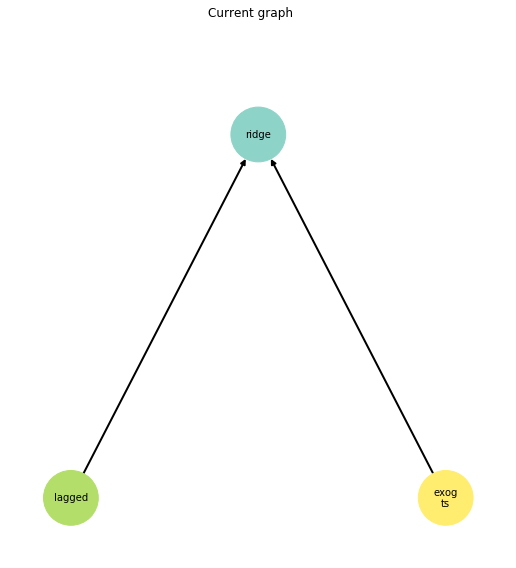

In [77]:
# Create a pipeline with different data sources in th nodes 
node_lagged = PrimaryNode('lagged')
node_lagged.custom_params = {'window_size':window_size}
node_exog = PrimaryNode('exog_ts')
node_exog.custom_params = {'window_size':window_size}
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged, node_exog])
exog_pipeline = Pipeline(node_ridge)

exog_pipeline.show()

In [78]:
# Fit it
exog_pipeline.fit(train_dataset)

# Predict
predicted = exog_pipeline.predict(predict_dataset)
predicted_values = np.ravel(np.array(predicted.predict))

In [79]:
df_predicted = pd.DataFrame({'Predicted':predicted_values})
df_predicted.index=test_data.index

In [80]:
df_result=pd.merge(df,df_predicted,how='left',left_index = True, right_index = True)

In [81]:
fig = px.line(df_result,x=df_result.index,y=['Train','Test','Predicted'])
fig.show()

In [82]:
print(f'Mean absolute error: {mean_absolute_error(test_data, df_predicted):.3f}')

Mean absolute error: 0.081
